<a href="https://colab.research.google.com/github/van-dang/FEniCS-Colab/blob/master/Diffusion2D_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem description

This program is used to simulate the diffusion process corresponding to this experiement:  https://www.youtube.com/watch?v=55CPfc9ij48

Let's set up a PDE-based simulation. 

Denote $u=u(x,t)$ to be the density of the diffusing material at location $x\in\Omega$ and time $t\in [0,T]$, 
the diffusion process can be described by the following equation

$$\frac{\partial u}{\partial t}=\kappa\,\Delta u+f$$
where $f$ is the source and $\kappa$ is the diffusion coefficient. 

Since there is no diffusion source inside the plate, we have $f=0$. 

At $t=0$, one put a crystal of Potassium Permanganate with a density $\rho$ in the center $x_c$ of the disk that can be modelled by a Direct Delta function as an inital condition, i.e $u(x,0)=\delta(x,x_c)=\begin{cases}
\rho & \mbox{if $x=x_c$}\\
0 & \mbox{otherwise}
\end{cases}$. 

The equation needs to be subjected to one or several boundary conditions on the boundary $\partial \Omega$. Since the water is not penetrated to the plate, the Neumann boundary condition is used $\nabla u\cdot {\bf n} = 0 \text{ on } \partial \Omega$.


We first discretize $\Omega$ into triangles and we look for solutions in a space of piece-wise linear functions. This process is automated in FEniCS and we just need to derive the weak forms.

Multiply both sides of the equation with a test function $v$ and integrate it over $\Omega$, we obtain

$$\displaystyle \int\limits_{\Omega} \frac{\partial u}{\partial t}\, v\, dx = \int\limits_{\Omega} \kappa\Delta u\, v\, dx \qquad (1).$$

Apply the Green's first identity, i. e.

$$\displaystyle \int\limits_{\Omega} \Delta u\, v\, dx=\int\limits_{\partial\Omega} \nabla u\cdot \mathbf{n}\, v\, ds - \int\limits_{\Omega} \nabla u \cdot\nabla v\, dx,$$

and notice that the boundary term vanishes due to the Neumann boundary conditions, Eq. (1) is rewritten as
$$\displaystyle \int\limits_{\Omega} \frac{\partial u}{\partial t}\, v\, dx =-\int\limits_{\Omega} \kappa \nabla u \cdot\nabla v\, dx\qquad (2).$$

Now, we discretize the time domain $[0, T]$ into subdomains $[t^{k+1},t^k]_{k=0,N-1}$ where $t^0=0$ and $t^N=T$. 

For any $t\in[t^{k+1},t^k]$, we can approximate the time derivatives 
$$\frac{\partial u(x,t)}{\partial t}\approx\frac{u(x,t^{k+1})-u(x,t^k)}{k}=\frac{u^{k+1}-u^k}{k}$$

On the right hand-side, we can choose

* $u=u^{k+1}$: implicit (backward Euler) method,

* or, $u=u^{k}$: explicit (forward Euler) method

In general, one can approximate $u\approx\text{um}:=\theta\, u^{k+1}+(1-\theta)\,u^k$ with $\theta\in[0,1]$. This is called the $\theta-$method for the time discretization.

Subsitute everything to Eq. (2) we have a time-space discretization of the heat equation

$$\displaystyle \int\limits_{\Omega} \frac{u^{k+1}-u^k}{k}\, v\, dx =-\int\limits_{\Omega} \kappa \nabla \text{um} \cdot\nabla v\, dx.$$

In FEniCS, we simply write

    r = (u - u0)/k*v*dx + kappa*inner(grad(um), grad(v))*dx 


# Setting a working environment with FEniCS

In [0]:
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
    
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time

import os, sys, shutil

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

!rm -rf * # clean up all files
# Useful commands
# Remove an empty folder      : os.rmdir("my_results")
# Remove a folder with files  : shutil.rmtree("results")
# Make a folder               : os.mkdir("my_results")
# Runtime/Change_runtime_type/Python3

dolfin version: 2018.1.0


# A diffusion simulator

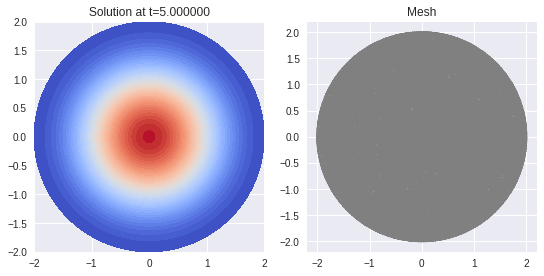

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


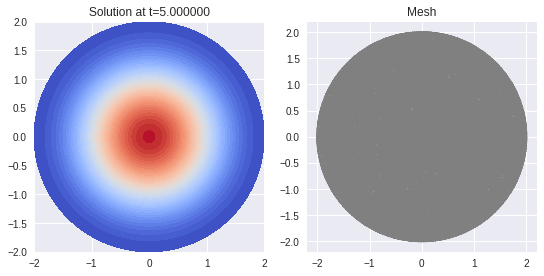

In [0]:
def plot_compact(u, t, stepcounter, QQ, pl, ax): # Compact plot utility function
  if stepcounter == 0:
    pl, ax = plt.subplots(); display(pl); clear_output(); # Plotting setup
  if stepcounter % 5 == 0:
    uEuclidnorm = project(sqrt(inner(u, u)), QQ); ax.cla(); fig = plt.gcf(); fig.set_size_inches(16, 4)
    plt.subplot(1, 2, 1); pp = plot(uEuclidnorm, cmap="coolwarm"); plt.title("Solution at t=%f" % (t)) # Plot norm of velocity
    if t == 0.: plt.axis(G); # plt.colorbar(pp, shrink=0.5); 
    plt.subplot(1, 2, 2);
    if t == 0.: plot(QQ.mesh()); plt.title("Mesh") # Plot mesh
    plt.tight_layout(); dpl = display(pl, display_id="test");
  
  return (pl, ax)

# Define domain and mesh
XMIN, XMAX = -2., 2.; 
YMIN, YMAX = -2., 2.; 
G = [XMIN, XMAX, YMIN, YMAX];
mresolution = 50;
# mesh = generate_mesh(Rectangle(Point(G[0], G[2]), Point(G[1], G[3])), mresolution)
mesh = generate_mesh(Circle(Point(0.0), 2.0), mresolution)

# Define finite element function space
degree = 1;
V = FunctionSpace(mesh, "CG", degree);

# Finite element functions
v = TestFunction(V); 
u = Function(V);

# Time parameters
theta = 1.0 # Implicit Euler
k = 0.05; # Time step
t, T = 0., 5.; # Start and end time

# Exact solution
kappa = 1e-1
rho = 1.0;
ue = Expression("rho*exp(-(x[0]*x[0]+x[1]*x[1])/(4*a*t))/(4*pi*a*t)", rho=rho,a=kappa, t=0, domain=mesh, degree=degree+1) 
ue.t = k/10.;
u0 = ue;

# Inititalize time stepping
pl, ax = None, None; 
stepcounter = 0; 
timer0 = time.clock()

# Time-stepping loop
while t < T: 
    # Time scheme
    um = theta*u + (1.0-theta)*u0 
    
    # Weak form of the heat equation in residual form
    r = (u - u0)/k*v*dx + k_coeff*inner(grad(um), grad(v))*dx 
    
    # Solve the Heat equation (one timestep)
    solve(r==0, u)  
    
    # Plot all quantities (see implementation above)
    pl, ax=plot_compact(u, t, stepcounter, V, pl, ax)
    
    # Shift to next timestep
    t += k; u0 = project(u, V); 
    ue.t = t;
    stepcounter += 1 

# Questions
1. Manipulate mresolution, execute the solver and draw conclusions about the timing, and the smoothness of the solution.
2. Manipulate kappa and draw a conclusion about the diffusion speed versus diffusion time.
3. Switch theta between 0 and 1 and draw a conclusion between the explicit and implicit method.
4. The current PDE model is not so close to the experiment. What can be the reasons?
